The following project is based on a real-world case from a multinational company. <br>
The objective is to forecast the monthly invoice fees.
<br>
The current method used is a simple linear regression model, this project explores time series forecasting techniques to achieve more accurate and reliable predictions.

The next processes were applied to the workflow:
- [Exploratory Data Analysis (Scatterplots, Time plots, Aggregation, etc.)](#1).
- [Autocorrelation Analysis (LAGS, ACF, ADF and KPSS tests, etc.)](#2).
- [Differencing (first and seasonal differencing, ACF and PACF graphs, unit root tests, etc.)](#3).
- [Modeling (SARIMA models, AIC and DIC, diagnostic plots, Portmanteau test, etc.)](#4).
- [Forecasting (SARIMAX, Prediction, confidence intervals, forecast visualization, etc.)](#5)


In [1]:
# Standard libraries
import os
import io
import time
import calendar

# Data handling
import pandas as pd
import numpy as np
from dateutil.parser import parse
import joblib

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import STL

# Statistical and time series analysis
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox



In [2]:
# Set the document path to the current directory
base_path = os.getcwd()

# Read the data file
df = pd.read_csv(os.path.join(base_path, "data.csv"))

# Drop all variables except the date and predicted variables
df = df[['FECHA_FACTURA','FEE_FACTURAS_EUROS']]

In [3]:
# Translate the variables names from Spanish to English
df.rename(columns={
    'FECHA_FACTURA': 'DATE_INVOICE',
    'FEE_FACTURAS_EUROS': 'INVOICE_FEE_EUROS',
}, inplace=True)

In [4]:
# Check column names and variable types
df.dtypes

DATE_INVOICE         object
INVOICE_FEE_EUROS    object
dtype: object

In [5]:
# Check some values to get a better understanding of the variable values
df.head()

,DATE_INVOICE,INVOICE_FEE_EUROS
0,8/1/1900,"32,361,960,159"
1,22/11/2006,"26,195,378,167"
2,22/03/2009,"31,894,778,021"
3,1/7/2009,"24,489,883,051"
4,22/12/2009,"27,442,656,203"


In [6]:
# Check some values to get a better understanding of the variable values
df.tail()

,DATE_INVOICE,INVOICE_FEE_EUROS
849395,22/06/2023,"38,681,757,931"
849396,22/07/2023,"22,805,662,621"
849397,22/07/2023,"33,500,030,150"
849398,29/08/2023,"19,415,440,672"
849399,29/08/2023,"28,088,112,222"


In [7]:
# Convert object type variable to numeric, replacing commas.
df['INVOICE_FEE_EUROS'] = pd.to_numeric(df['INVOICE_FEE_EUROS'].str.replace(',', ''), errors='coerce')

# Convert object type date variable to date format.
df['DATE_INVOICE'] = pd.to_datetime(df['DATE_INVOICE'], format='%d/%m/%Y')

# Check column names and variable types to confirm transformation
df.dtypes

DATE_INVOICE         datetime64[ns]
INVOICE_FEE_EUROS           float64
dtype: object

In [8]:
# We check if there are any Null values in the dataset
print(df.isnull().sum())

DATE_INVOICE           0
INVOICE_FEE_EUROS    404
dtype: int64


In [9]:
# Drop values with missing Invoice fee Euros, likely due to data entry errors.
df = df.dropna(subset=['INVOICE_FEE_EUROS'])

In [10]:
# We check if there are any Null values in the dataset
print(df.isnull().sum())

DATE_INVOICE         0
INVOICE_FEE_EUROS    0
dtype: int64


In [11]:
# Check instances per year
print(df['DATE_INVOICE'].dt.year.value_counts().sort_index())

DATE_INVOICE
1900         1
2006         1
2009         5
2010        56
2011       205
2012       240
2013       400
2014       560
2015      1182
2016      2191
2017     15164
2018    129371
2019    136091
2020    132595
2021    132147
2022    134593
2023    128419
2024     35775
Name: count, dtype: int64


There is a record from the year 1900, a data entry error since the business was not operating at that time (I would think).
But it seems that the business did not reach the current operation flow until 2018, therefore we want to make our model only with data after that date. since it will better capture recent trends and accurately simulate short-term future behavior.

In [12]:
# Create a year index
df['DATE'] = df['DATE_INVOICE']
df.set_index('DATE', inplace=True)

# Sort values
df = df.sort_values(by=['DATE_INVOICE'], ascending=True)

# Drop columns below the year 2018 due to different operastional behavior
df = df[~(df['DATE_INVOICE'] < '2018-01-01')]

# Check instances per year
print(df['DATE_INVOICE'].dt.year.value_counts().sort_index())

DATE_INVOICE
2018    129371
2019    136091
2020    132595
2021    132147
2022    134593
2023    128419
2024     35775
Name: count, dtype: int64


# <a id='1'>Exploratory Data Analysis</a>

<Figure size 1000x600 with 0 Axes>

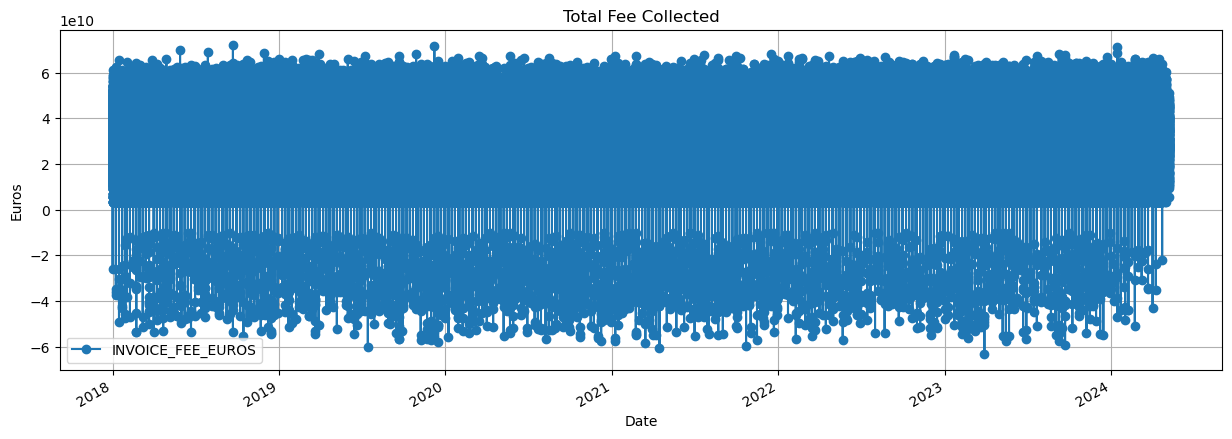

In [13]:
# Plot the original time series
# Let's observe the records over time to understand the date distribution in our dataset
plt.figure(figsize=(10,6))
df[['INVOICE_FEE_EUROS']].plot(figsize=(15,5), marker='o')
plt.title("Total Fee Collected") 
plt.ylabel("Euros")
plt.xlabel("Date")
plt.grid(True)
plt.show()

There are too many observations for the model to extract meaningful insights at this level. <br>
Let's examine the monthly data instead, as this is the periodicity required for the analysis. <br>
We can also observe negative values in the data, negative values represent self-issued invoices by the company.
These will be included in the analysis, as they are part of the overall financial activity.

<Figure size 1000x600 with 0 Axes>

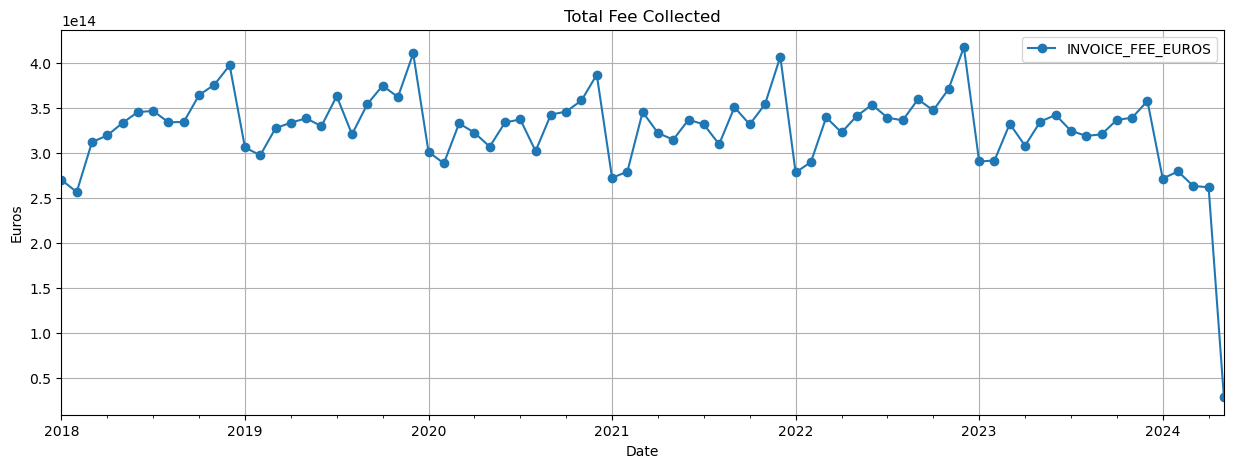

In [14]:
# Plot the original time series on a monthly basis
plt.figure(figsize=(10,6))
df[['INVOICE_FEE_EUROS']].resample('M').sum().plot(figsize=(15,5), marker='o')
plt.title("Total Fee Collected")
plt.ylabel("Euros")
plt.xlabel("Date") 
plt.grid(True)
plt.show()

There are some interesting observations: <br>
1) The data does not appear to follow a clear trend or cycle. Although it shows some seasonality particularly for the month of December, where a recurrent spike is observed. <br>
2) it seems that the data of May is pretty low, that makes sense since the last data point was collected on May 8th, so we should exclude the month of May from the analysis.

In [15]:
# Drop columns above 2018-05 due to lack of data.
df = df[~(df['DATE_INVOICE'] >= '2024-05-01')]

# Extract the year and month from the invoice date for time-based aggregation.
df['year'] = df['DATE_INVOICE'].dt.year
df['month'] = df['DATE_INVOICE'].dt.month

# Aggregate total invoice fees by year and month.
# This groups the data at a monthly level and sums the invoice fees for each period.
monthly_totals = (
    df.groupby(['year', 'month'], as_index=False)['INVOICE_FEE_EUROS']
      .sum()
      .sort_values(['year', 'month'])
)

# Create a new datetime column representing the first day of each month.
# This will serve as a proper time index for time series analysis.
monthly_totals['date'] = pd.to_datetime(
    monthly_totals['year'].astype(str) + '-' + monthly_totals['month'].astype(str) + '-01'
)

# Display the resulting dataset to verify the structure and monthly aggregation.
print(monthly_totals)

    year  month  INVOICE_FEE_EUROS       date
0   2018      1       2.699109e+14 2018-01-01
1   2018      2       2.564300e+14 2018-02-01
2   2018      3       3.117900e+14 2018-03-01
3   2018      4       3.192077e+14 2018-04-01
4   2018      5       3.330916e+14 2018-05-01
..   ...    ...                ...        ...
71  2023     12       3.573466e+14 2023-12-01
72  2024      1       2.714007e+14 2024-01-01
73  2024      2       2.792275e+14 2024-02-01
74  2024      3       2.630964e+14 2024-03-01
75  2024      4       2.617260e+14 2024-04-01

[76 rows x 4 columns]


Now that we have the structure that we need for the analysis, we can now compare the monthly behavior of our variable across different years.

C:\Users\beltr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\beltr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


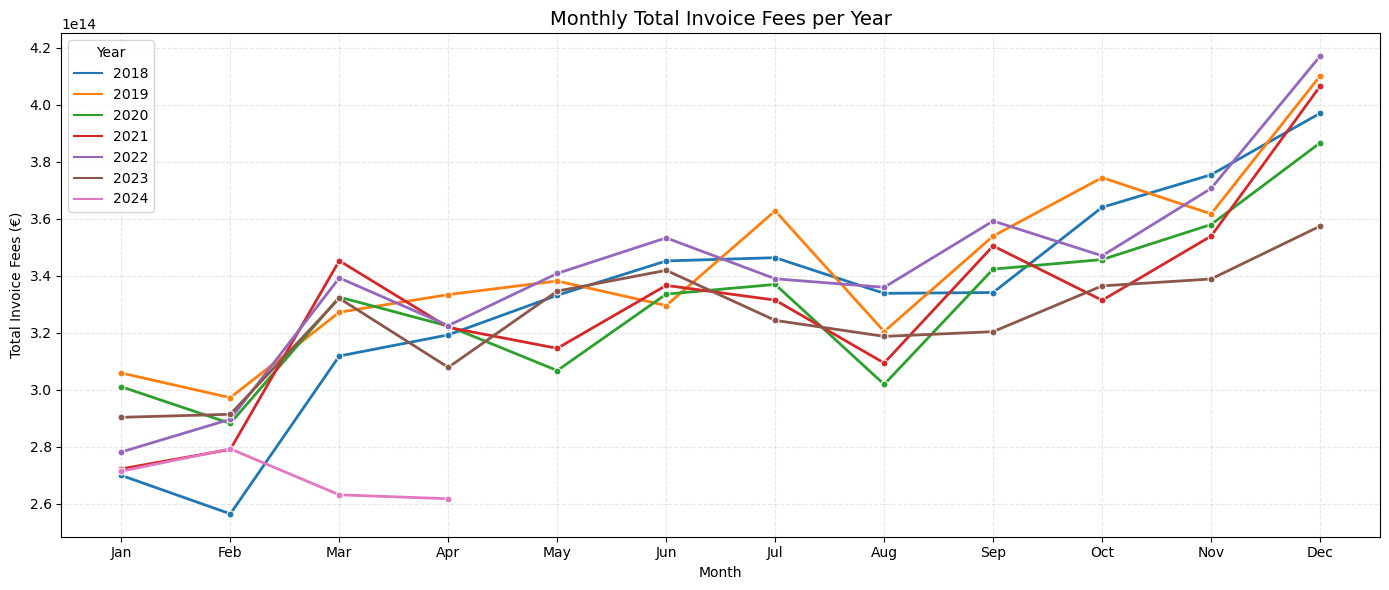

In [16]:
# Plot monthly totals for each year
fig, ax = plt.subplots(figsize=(14, 6))

# Choose a palette to better distinguish the lines for each year.
palette = sns.color_palette('tab10', n_colors=len(monthly_totals['year'].unique()))
sns.lineplot(
ax=ax,
data=monthly_totals,
x='month',
y='INVOICE_FEE_EUROS',
hue='year',
palette=palette,
marker='o',
linewidth=2,
markersize=5,
errorbar=None
)

# Map months 1–12 to abbreviated month names
ax.set_xticks(range(1, 13))
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
ax.set_xlabel("Month")
ax.set_ylabel("Total Invoice Fees (€)")

# Add grid to improve layout
ax.grid(alpha=0.3, linestyle='--')
ax.set_title("Monthly Total Invoice Fees per Year", fontsize=14, fontweight='medium')
plt.legend(title='Year', loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


The seasonal pattern in the data is now more evident, particularly the spike observed every December. <br>
Additionally, there is a subtle upward trend, indicating a gradual increase in values over the course of the year.

# <a id='2'>Autocorrelation Analysis</a>

### LAGS Analysis ###

Given the recurring patterns observed in certain months, we have potential seasonality in the data. To further investigate, we perform a lags analysis, which allows us to examine how the time series values relate to their past observations. This method helps identify autocorrelation and potential seasonal effects by plotting each observation against its values from previous months.

In this analysis, we resample the data to a monthly frequency and create lag plots for up to 24 months (2 years)

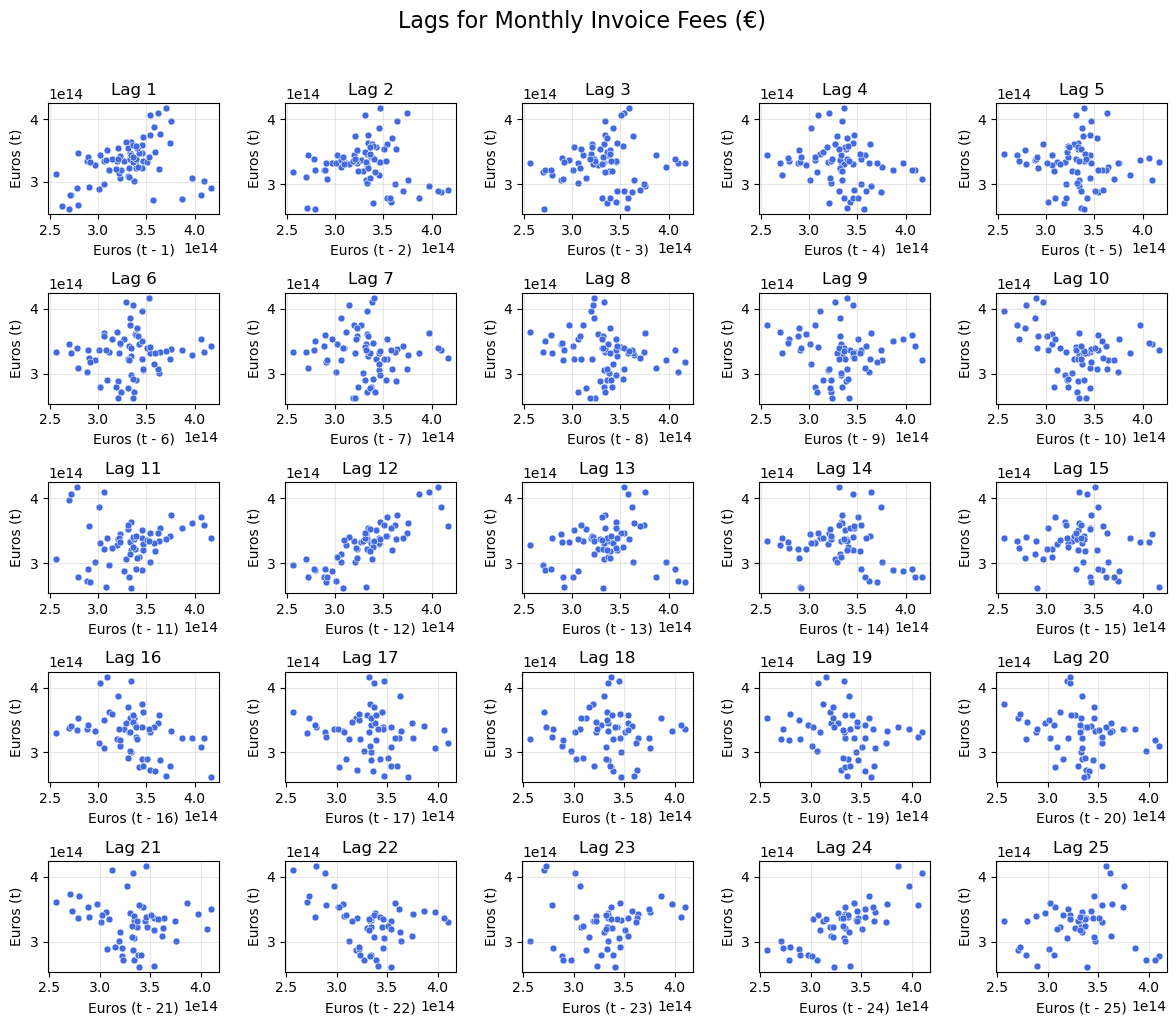

In [17]:
# Choose number of lags to visualize (2 years)
max_lag = 24

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(12, 10))
axes = axes.flatten()

for k, ax in enumerate(axes, start=1):
    df_temp = pd.DataFrame({'x': monthly_totals['INVOICE_FEE_EUROS'].shift(k), 'y': monthly_totals['INVOICE_FEE_EUROS']})
    sns.scatterplot(x='x', y='y', data=df_temp, ax=ax, s=25, color='royalblue')
    ax.set_title(f'Lag {k}')
    ax.set_xlabel(f'Euros (t - {k})')
    ax.set_ylabel('Euros (t)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Lags for Monthly Invoice Fees (€)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In these graphs, the monthly invoice data is plotted against its previous values, where lag = 1 represents the previous month, lag = 2 the month before that, and so on. <br>
Most lags show scattered points without a clear pattern, indicating little direct correlation between consecutive months. Except for lags 12 and 24, which compares the monthly data againts the same month of the last year and two years ago, which may confirm our suspition of seasonality in the data.
It looks like it has positive autocorrelation between the same months of the past year.

### ACF Plots
Based on our observations so far, there appears to be autocorrelation between the same months in different years. To confirm this suspicion and quantify the strength of these correlations, we will perform an Autocorrelation Function (ACF) analysis.

<Figure size 1000x400 with 0 Axes>

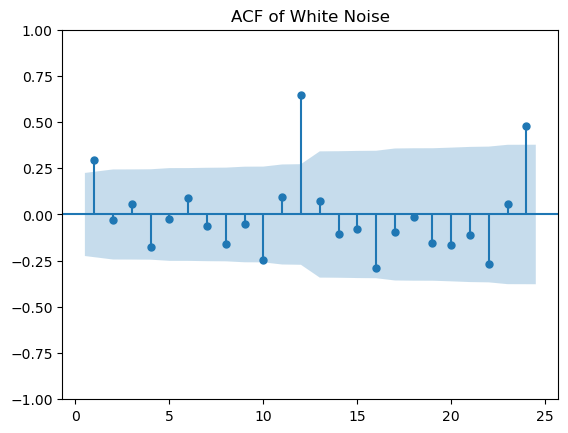

In [18]:
# Confirm seasonality behavior with white noise analysys for monthly totals
# Plot time series
plt.figure(figsize=(10, 4))
plot_acf(monthly_totals['INVOICE_FEE_EUROS'], lags=24, zero=False)
plt.title("ACF of White Noise")
plt.show()

As expected, the ACF plot shows significant spikes at lags 12 and 24, which fall outside the confidence bounds. This indicates strong autocorrelation at these lags, confirming that the data exhibits seasonality, with patterns repeating in the same months each year.
Importantly, the autocorrelation does not exhibit a trending pattern, suggesting that the data likely does not contain a long-term trend.
<br>
Since __seasonality is present__ and there is __no clear trend__, we decide to make an __ARIMA model instead of an ETS model__


In [19]:
# We will perform statistical tests for stationarity (ADF and KPSS), also known as unit root tests.
#ADf test
result = adfuller(monthly_totals['INVOICE_FEE_EUROS'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# KPSS test
result = kpss(monthly_totals['INVOICE_FEE_EUROS'], regression='c', nlags=12)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.1301161475688843
p-value: 0.7029137602223487
KPSS Statistic: 0.17764828620458212
p-value: 0.1


C:\Users\beltr\AppData\Local\Temp\ipykernel_19428\2335854822.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(monthly_totals['INVOICE_FEE_EUROS'], regression='c', nlags=12)


ADF: The null hypothesis (H₀): Series has a unit root → non-stationary. <br>
Since p = 0.70 > 0.05, we fail to reject H₀. <br>
__ADF suggests the series is non-stationary.__ <br> 
<br>
KPSS: The null hypothesis (H₀): Series is stationary (around a constant or trend). <br>
Since p ≥ 0.10, we fail to reject H₀. <br>
__KPSS suggests the series is stationary.__<br>
<br>
We got mixed results, but we should try to get stationarity in the data for both tests.

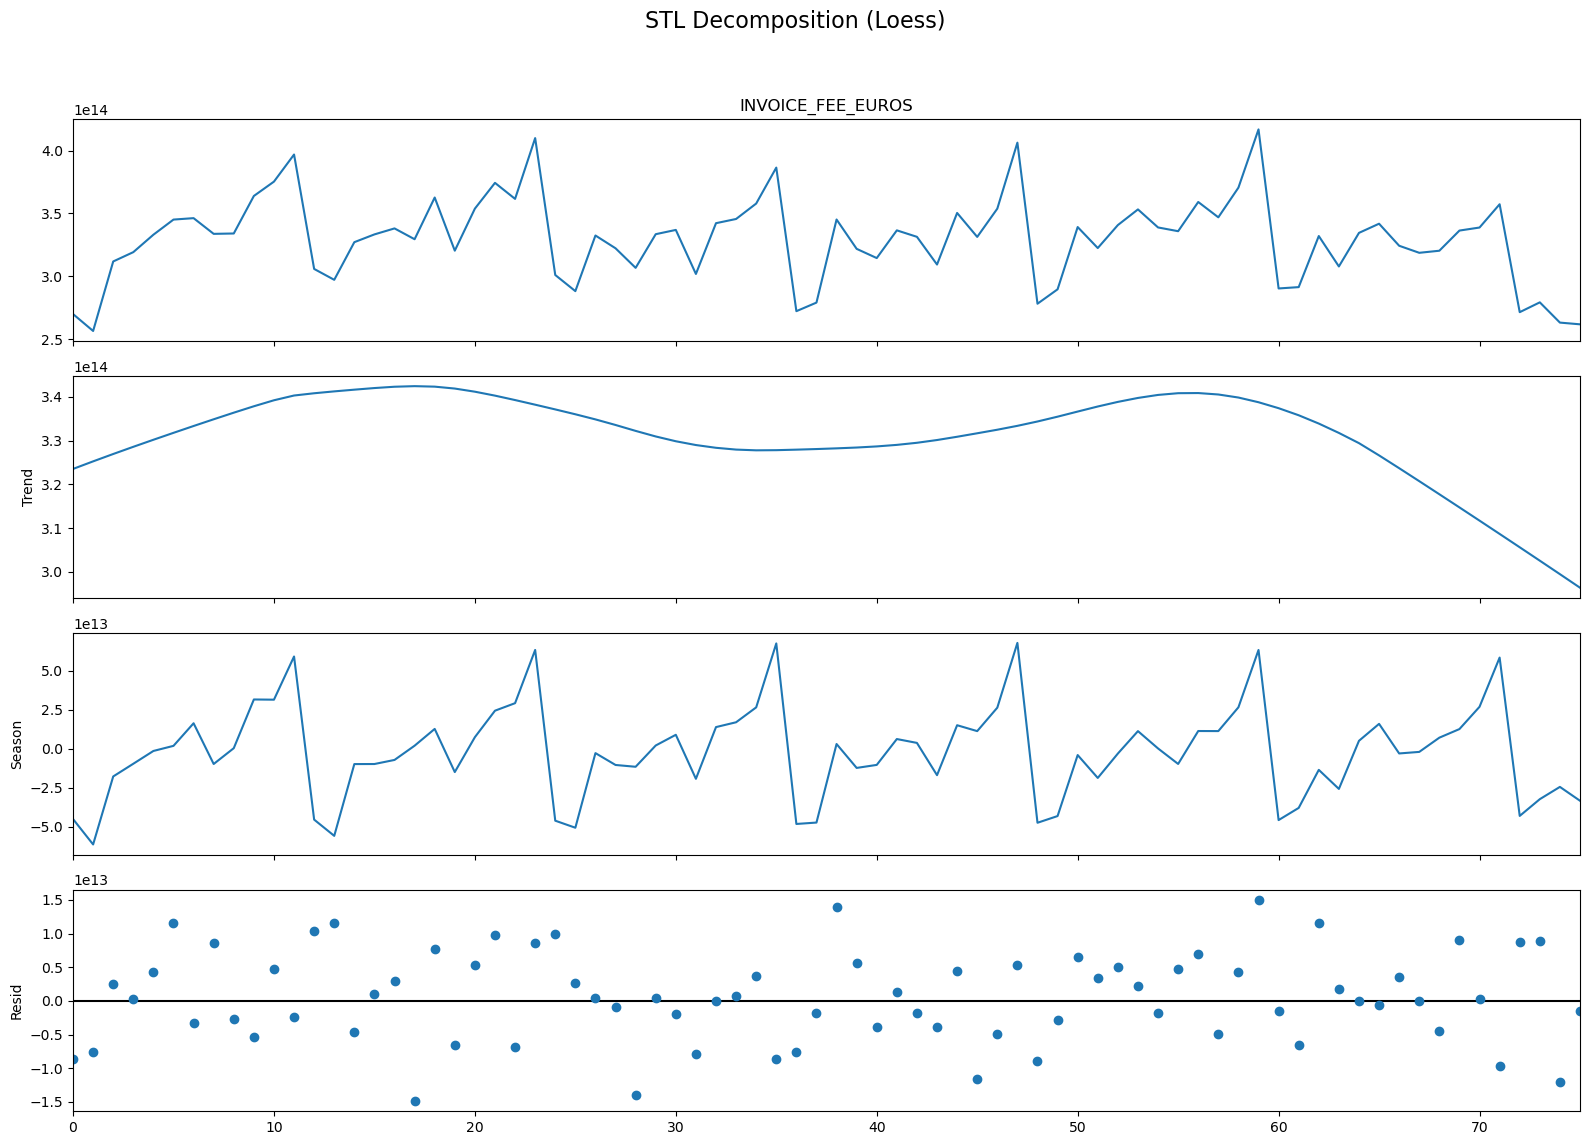

In [20]:
# Although we are doing ARIMA model, let's observe STL Seasonal and Trend decomposition using Loess.
# STL Seasonal and Trend decomposition using Loess
stl = STL(monthly_totals['INVOICE_FEE_EUROS'], period=12)
result = stl.fit()

# Plot the STL decomposition
plt.rcParams.update({'figure.figsize': (16, 12)})
fig = result.plot()
fig.suptitle('STL Decomposition (Loess)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# <a id='3'>Differencing</a>
Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) seasonality.

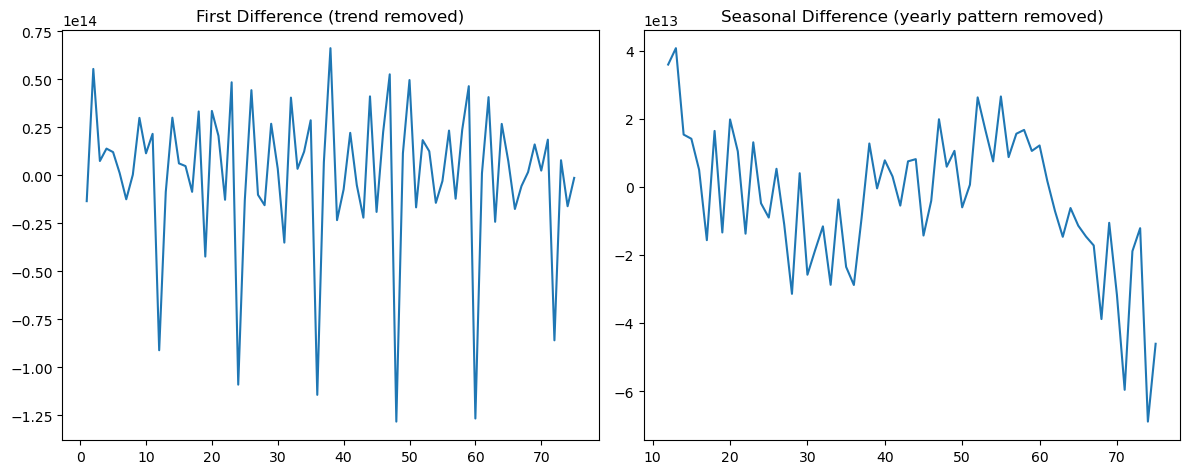

In [21]:
# let's try to make it stationary by calculating the monthly differences (month minus last month)
monthly_totals["diff"] = monthly_totals["INVOICE_FEE_EUROS"].diff(1)  # y[t] - y[t-1]

# We need to drop the first value because it will be NAN due to first month not having month to differenciate
# Store it in another Data to not loose values in our original dataset
monthly_diff = monthly_totals.copy(deep=True)
monthly_diff = monthly_diff.dropna()
monthly_diff = monthly_diff.drop(columns="INVOICE_FEE_EUROS")

# Do also seasonal difference (month minus same month of last year).
monthly_totals["diff_seasonal"] = monthly_totals["INVOICE_FEE_EUROS"].diff(12)  # y[t] - y[t-1]

# Store it in another Data to not loose values in oru original dataset
monthly_diff_seasonal = monthly_totals.copy(deep=True)
monthly_diff_seasonal = monthly_diff_seasonal.dropna()
monthly_diff_seasonal = monthly_diff_seasonal.drop(columns="INVOICE_FEE_EUROS")
monthly_diff_seasonal = monthly_diff_seasonal.drop(columns="diff")

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
monthly_diff["diff"].plot(ax=axes[0], title="First Difference (trend removed)")
monthly_diff_seasonal["diff_seasonal"].plot(ax=axes[1], title="Seasonal Difference (yearly pattern removed)")
plt.tight_layout()
plt.show()

By visualizing the differenced data, we notice that
the first graph does not shows having a trend but you can notice some seasonality, the spikes are more frequent and marked.
The second graph does not exhibit noticeable seasonality, but there appears to be a gradual declining trend over the years. <br>

We will perform an ACF analysis and unit root tests on both differenced datasets to determine whether they have achieved stationarity.


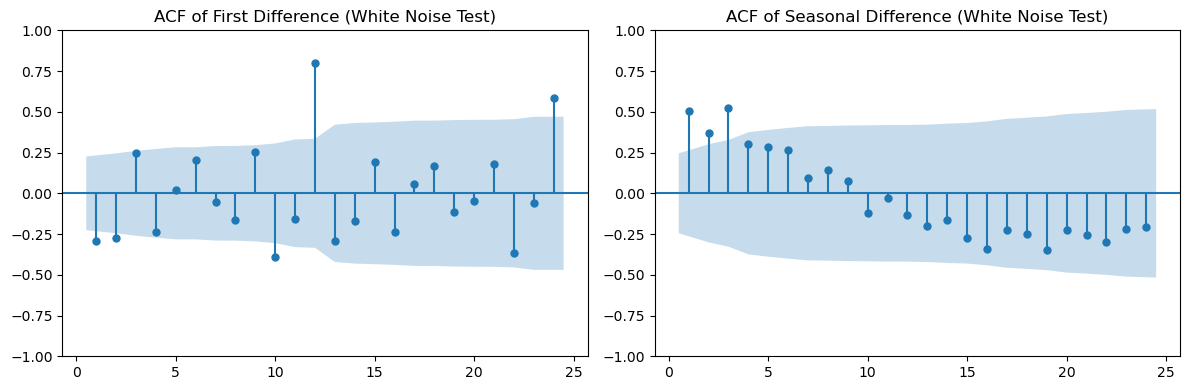

In [22]:
# Combined ACF plots for white noise analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF for first-differenced series
plot_acf(monthly_diff["diff"], lags=24, zero=False, ax=axes[0])
axes[0].set_title("ACF of First Difference (White Noise Test)")

# ACF for seasonal-differenced series
plot_acf(monthly_diff_seasonal["diff_seasonal"], lags=24, zero=False, ax=axes[1])
axes[1].set_title("ACF of Seasonal Difference (White Noise Test)")

plt.tight_layout()
plt.show()

1) The first graph shows even more autocorrelation that our original data, implying that the differenced dataset is less stationary.
2) The second one is decreasing slowly, which could mean trending behavior in out data

In [23]:
# Perform Unit Root Tests 
# First difference tests
adf_first = adfuller(monthly_diff['diff'])
kpss_first = kpss(monthly_diff['diff'], regression='c', nlags=12)

# Seasonal difference tests
adf_seasonal = adfuller(monthly_diff_seasonal['diff_seasonal'])
kpss_seasonal = kpss(monthly_diff_seasonal['diff_seasonal'], regression='c', nlags=12)

unit_root_results = pd.DataFrame({
    'Test': ['ADF', 'KPSS'],
    'First Difference': [
        f"Statistic: {adf_first[0]:.4f}, p-value: {adf_first[1]:.4f}",
        f"Statistic: {kpss_first[0]:.4f}, p-value: {kpss_first[1]:.4f}"
    ],
    'Seasonal Difference': [
        f"Statistic: {adf_seasonal[0]:.4f}, p-value: {adf_seasonal[1]:.4f}",
        f"Statistic: {kpss_seasonal[0]:.4f}, p-value: {kpss_seasonal[1]:.4f}"
    ]
})

print("\n=== Unit Root Test Results (ADF & KPSS) ===")
print(unit_root_results.to_string(index=False))



=== Unit Root Test Results (ADF & KPSS) ===
Test                    First Difference                 Seasonal Difference
 ADF Statistic: -2.0700, p-value: 0.2567 Statistic: -1.1295, p-value: 0.7032
KPSS  Statistic: 0.2886, p-value: 0.1000  Statistic: 0.2230, p-value: 0.1000


C:\Users\beltr\AppData\Local\Temp\ipykernel_19428\2413030418.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_first = kpss(monthly_diff['diff'], regression='c', nlags=12)
C:\Users\beltr\AppData\Local\Temp\ipykernel_19428\2413030418.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_seasonal = kpss(monthly_diff_seasonal['diff_seasonal'], regression='c', nlags=12)


The differenced datasets did not achieve the desired non stationarity behavior since the p-value for the ADF test is still bigger than .05 <br>
We would have to create a double differenced data set by combining both differences.

In [24]:
# We apply seasonal difference and a first difference to obtain stationary data.
monthly_totals["diff_combined"] = monthly_totals["INVOICE_FEE_EUROS"].diff(1).diff(12)  # y[t] - y[t-1]

# Store it in another Data to not loose values in our original dataset
monthly_diff_combined = monthly_totals.copy(deep=True)
monthly_diff_combined = monthly_diff_combined.dropna()
monthly_diff_combined = monthly_diff_combined.drop(columns="INVOICE_FEE_EUROS")
monthly_diff_combined = monthly_diff_combined.drop(columns="diff")
monthly_diff_combined = monthly_diff_combined.drop(columns="diff_seasonal")

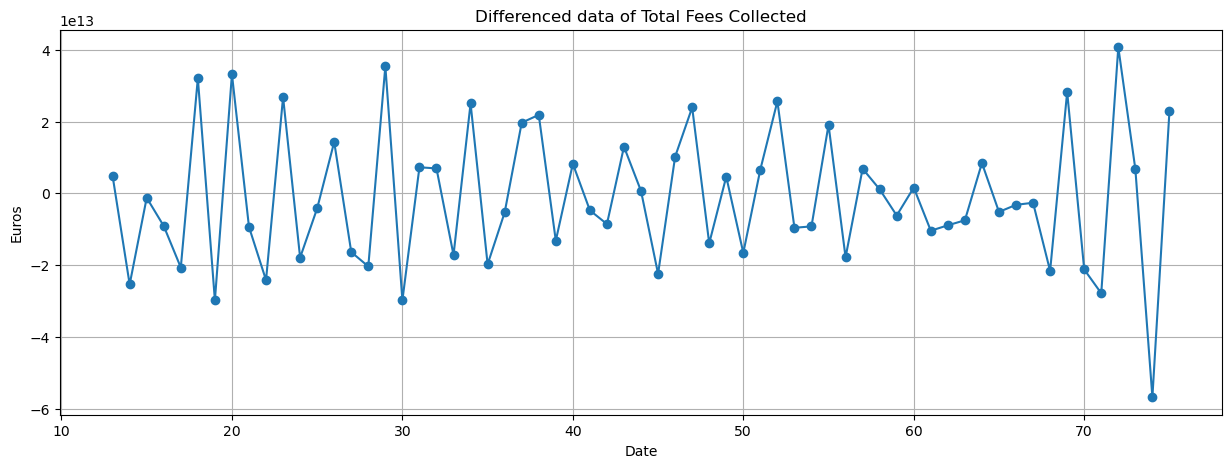

In [25]:
# Plot the original time series on a monthly basis
plt.figure(figsize=(10,6))
monthly_diff_combined["diff_combined"].plot(figsize=(15,5), marker='o')
plt.title("Differenced data of Total Fees Collected")
plt.ylabel("Euros")
plt.xlabel("Date") 
plt.grid(True)
plt.show()

This graph now appears much cleaner, showing no clear trend or seasonal patterns. The behavior resembles random noise (white noise), indicating that the data is likely stationary.

<Figure size 1000x400 with 0 Axes>

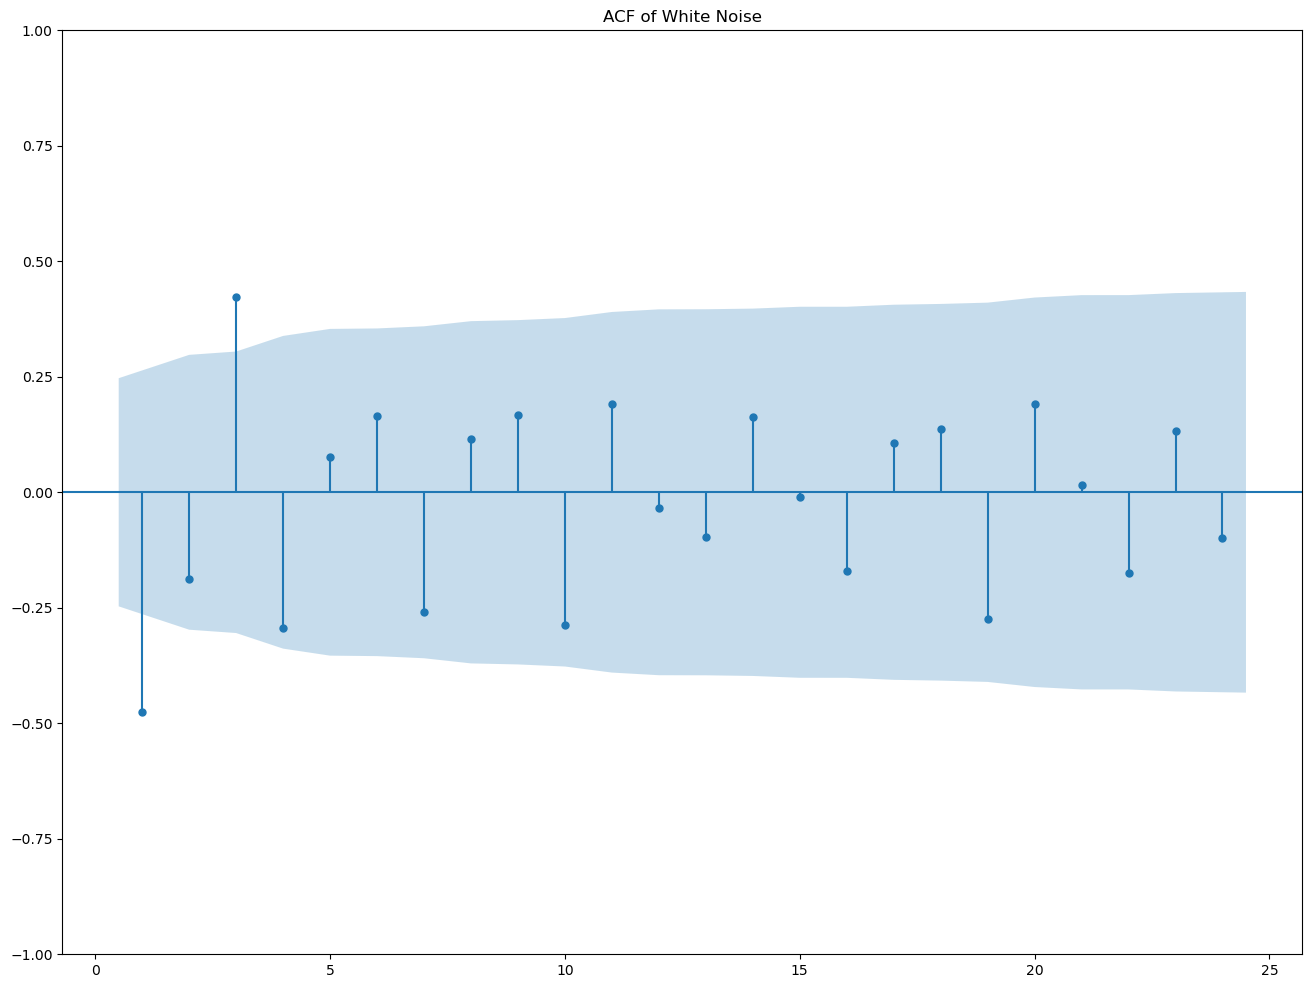

In [26]:
# Confirm seasonlaity behavior with white noise analysys for differenced data
# Plot time series
plt.figure(figsize=(10, 4))
plot_acf(monthly_diff_combined["diff_combined"], lags=24, zero=False)
plt.title("ACF of White Noise")
plt.show()

<Figure size 1000x400 with 0 Axes>

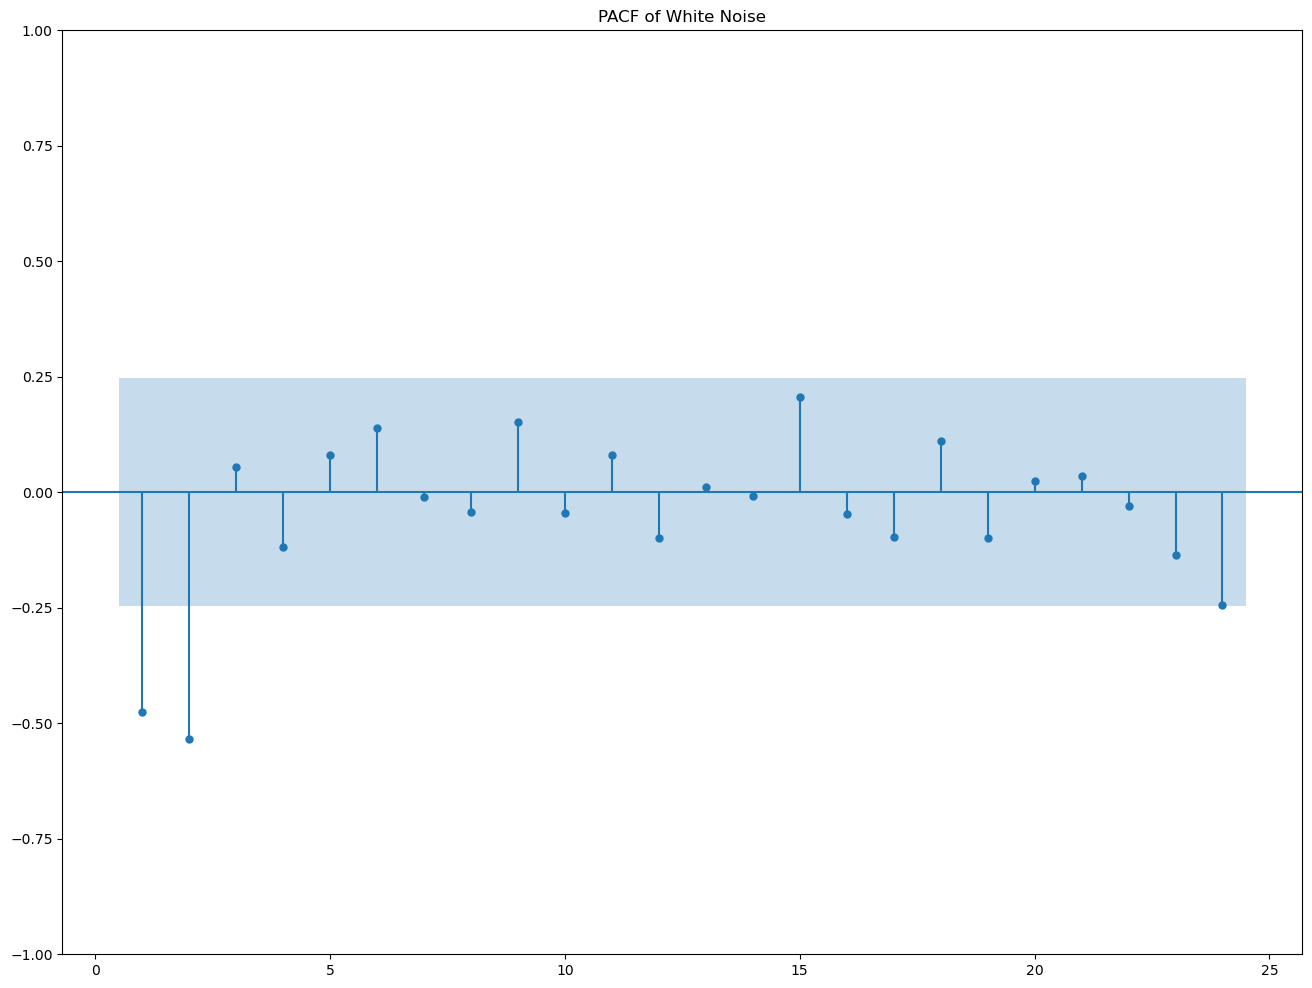

In [27]:
# Confirm seasonality behavior with white noise analysis for monthly
# Plot PACF of the differenced series
plt.figure(figsize=(10, 4))
plot_pacf(monthly_diff_combined["diff_combined"], lags=24, zero=False, method='ywm')
plt.title("PACF of White Noise")
plt.show()

In [28]:
# Perform Unit Root test for our newly differenced data
#ADf test
result = adfuller(monthly_diff_combined["diff_combined"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# KPSS test
result = kpss(monthly_diff_combined["diff_combined"], regression='c', nlags=12)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -12.105485637912164
p-value: 1.9734740934891984e-22
KPSS Statistic: 0.14125195392140533
p-value: 0.1


C:\Users\beltr\AppData\Local\Temp\ipykernel_19428\2110099095.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(monthly_diff_combined["diff_combined"], regression='c', nlags=12)


Now both ADF AND KPSS test confirm not stationarity in our data. 
<br>
The next step for modelling an ARIMA model are more technical.

With the ACF and PACF plots we define the values for p and q in our ARIMA model. <br>
The PACF cutting off (or prominent) at lag 2 suggests a non-seasonal AR(2) (p = 2). <br>
The ACF showing spikes up to lag 3 suggests a non-seasonal MA up to order 3 (q = 1..3). <br>
We use a SARIMA model because it can work with the differenced dataset for modeling while producing forecasts in the original scale.

So a sensible set of candidate models (all with d=1, D=1, s=12) is:

SARIMA(2,1,1)(0,1,0)[12] -> parsimonious, keeps MA small.

SARIMA(2,1,3)(0,1,0)[12] -> allows the ACF lag-3 spike to be captured.

SARIMA(1,1,1)(0,1,0)[12] -> simple baseline (useful as a check).

SARIMA(2,1,0)(0,1,0)[12] -> lagged observations as input

SARIMA(0,1,3)(0,1,0)[12] -> lagged errors as input
E))

# <a id='4'>Modeling</a>
In this section, we will test the different SARIMA models and use AIC (Akaike Information Criterion) and DIC (Deviance Information Criterion) to select the best model of our candidates. We will evaluate the best resulted model by analysing diagnostic plots and see if the autocorrelation graph looks like white noise. then, apply the the Portmanteau test for autocorrelation and then check coefficient significance.

In [29]:
# Drop difference created from original data
monthly_totals = monthly_totals.drop(columns=["diff_combined", "diff", "diff_seasonal", "year", "month"])

In [30]:
# Create list of candidate models
candidates = [
    ((2,1,1),(0,1,0,12)),
    ((2,1,3),(0,1,0,12)),
    ((1,1,1),(0,1,0,12)),
    ((2,1,0),(0,1,0,12)),
    ((0,1,3),(0,1,0,12))
]

results = []
for order, seasonal in candidates:
    print("Fitting SARIMA", order, seasonal)
    model = sm.tsa.SARIMAX(monthly_totals["INVOICE_FEE_EUROS"], order=order, seasonal_order=seasonal,
                           enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False, method_kwargs={"warn_convergence": False})
    results.append((order, seasonal, res))
    print(res.summary().tables[1])
    print("AIC:", res.aic, "BIC:", res.bic)
    print("-"*60)

# Collect AIC/BIC
rows = []
for order, seasonal, res in results:
    rows.append({"order":order, "seasonal":seasonal, "aic":res.aic, "bic":res.bic})
df = pd.DataFrame(rows).sort_values("aic")
print(df)

Fitting SARIMA (2, 1, 1) (0, 1, 0, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8055      0.153     -5.256      0.000      -1.106      -0.505
ar.L2         -0.6090      0.105     -5.773      0.000      -0.816      -0.402
ma.L1          0.1039      0.185      0.561      0.575      -0.259       0.467
sigma2      1.967e+26        nan        nan        nan         nan         nan
AIC: 3875.446959034344 BIC: 3883.8904544910374
------------------------------------------------------------
Fitting SARIMA (2, 1, 3) (0, 1, 0, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7457      0.261     -2.860      0.004      -1.257      -0.235
ar.L2         -0.4361      0.256     -1.701      0.089      -0.938       0.066
ma.L1          0.0510   

C:\Users\beltr\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
C:\Users\beltr\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
C:\Users\beltr\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7125      0.105     -6.798      0.000      -0.918      -0.507
ar.L2         -0.5703      0.104     -5.496      0.000      -0.774      -0.367
sigma2      2.059e+26        nan        nan        nan         nan         nan
AIC: 3875.0674383281043 BIC: 3881.4000599206242
------------------------------------------------------------
Fitting SARIMA (0, 1, 3) (0, 1, 0, 12)


C:\Users\beltr\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3934      0.109     -3.619      0.000      -0.606      -0.180
ma.L2         -0.4832      0.089     -5.419      0.000      -0.658      -0.308
ma.L3          0.3448      0.111      3.105      0.002       0.127       0.563
sigma2      2.057e+26   3.47e-29   5.93e+54      0.000    2.06e+26    2.06e+26
AIC: 3748.8692776384264 BIC: 3757.1794274140493
------------------------------------------------------------
       order       seasonal          aic          bic
1  (2, 1, 3)  (0, 1, 0, 12)  3741.729101  3754.194326
4  (0, 1, 3)  (0, 1, 0, 12)  3748.869278  3757.179427
3  (2, 1, 0)  (0, 1, 0, 12)  3875.067438  3881.400060
0  (2, 1, 1)  (0, 1, 0, 12)  3875.446959  3883.890454
2  (1, 1, 1)  (0, 1, 0, 12)  3891.105104  3897.437725


The best overall fit by information criteria is the SARIMA (2, 1, 3)(0, 1, 0, 12). Both AR(1) and MA(2) are statistically significant, which means that it exist a relationship between the series recent past and short-term corrections. Now, we will observe the residuals behavior.

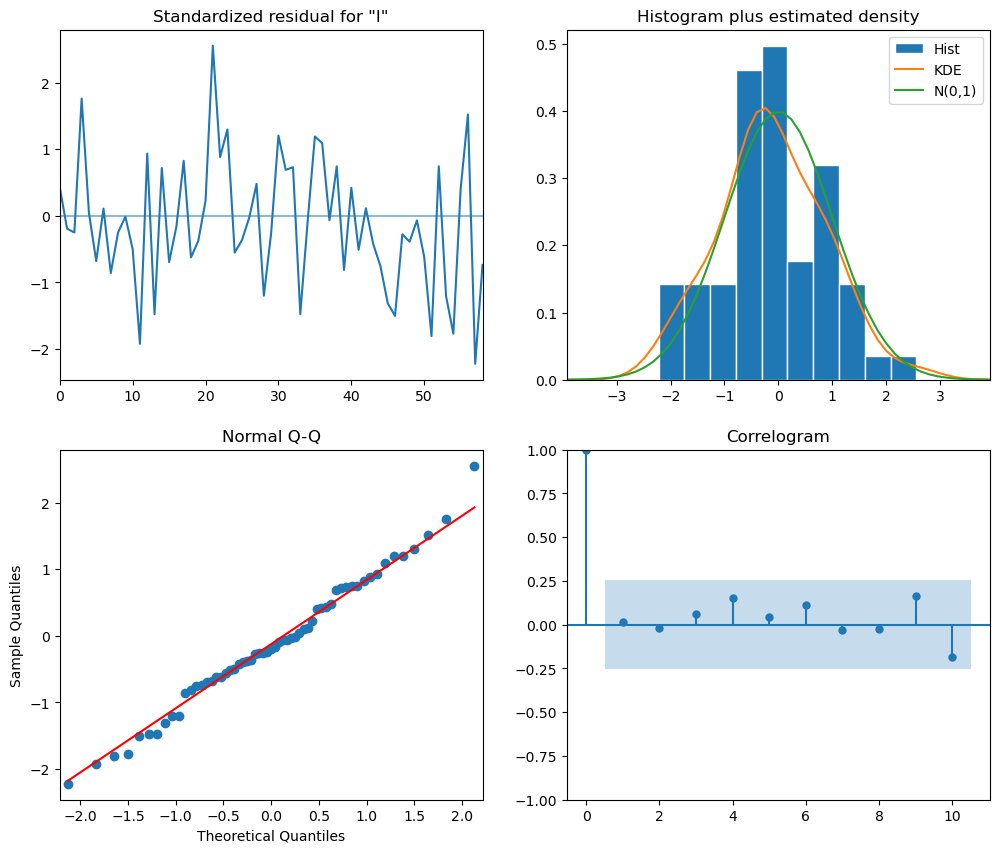

In [31]:
# Evaluating the best model
best_res = results[1][2]

# Diagnostic plots
best_res.plot_diagnostics(figsize=(12,10))
plt.show()

1) The residuals fluctuate randomly around zero, with no visible trend or periodic pattern. This suggests that the residuals behave roughly like white noise.
2) The histogram is approximately bell-shaped and centered around zero -> Residuals are approximately normally distributed.
3) The points mostly lie along the red reference line -> Confirms the residuals are roughly normal.
4) No significant autocorrelation remains in the residuals -> they are effectively white noise.

This visualizations confirm that our estimated model is a good fit for the data.

In [32]:
# Portmanteau (Q) test using JungBox
best_res.test_serial_correlation(method="ljungbox", lags=[6,12,18,24])

array([[[ 2.7391711 ,  7.73319901, 11.9594753 , 17.94494073],
        [ 0.84079899,  0.80561702,  0.84932266,  0.80567111]]])

All p-values are very high (>0.8), much greater than 0.05. We fail to reject the null hypothesis of no autocorrelation.
That means the residuals behave like white noise.

In [33]:
# 3. Check coefficient significance
print(best_res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                   INVOICE_FEE_EUROS   No. Observations:                   76
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 12)   Log Likelihood               -1864.865
Date:                             Mon, 27 Oct 2025   AIC                           3741.729
Time:                                     11:34:48   BIC                           3754.194
Sample:                                          0   HQIC                          3746.595
                                              - 76                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7457      0.261     -2.860      0.004      -1.257      -0.235
ar.L2         -0.4361      

Key observartions:
1) Strong AR(1) and MA(2) terms -> captures short-term patterns effectively.
2) Residuals are uncorrelated, normally distributed, and homoscedastic.

__Model (2,1,3)(0,1,0,12) fits the data well, passes all diagnostic tests, and has the best information criteria.__

# <a id='5'>Forecasting</a>
In this section we predict future Fees values based on the best resulted model.

In [34]:
# Forecasting with the best model
model = sm.tsa.SARIMAX(
    monthly_totals["INVOICE_FEE_EUROS"],
    order=(2,1,3),
    seasonal_order=(0,1,0,12)
)
results = model.fit()

In [35]:
# Forecasting the next year
n_steps = 12
forecast = results.get_forecast(steps=n_steps)

# Extract forecast results
forecast_df = forecast.summary_frame()
forecast_df.head()

INVOICE_FEE_EUROS,mean,mean_se,mean_ci_lower,mean_ci_upper
76,2.862191e+14,1.325645e+13,2.602369e+14,3.122012e+14
77,2.896871e+14,1.813277e+13,2.541476e+14,3.252267e+14
78,2.753516e+14,2.210269e+13,2.320311e+14,3.186721e+14
79,2.673136e+14,2.603151e+13,2.162927e+14,3.183344e+14
80,2.708620e+14,2.920946e+13,2.136125e+14,3.281115e+14


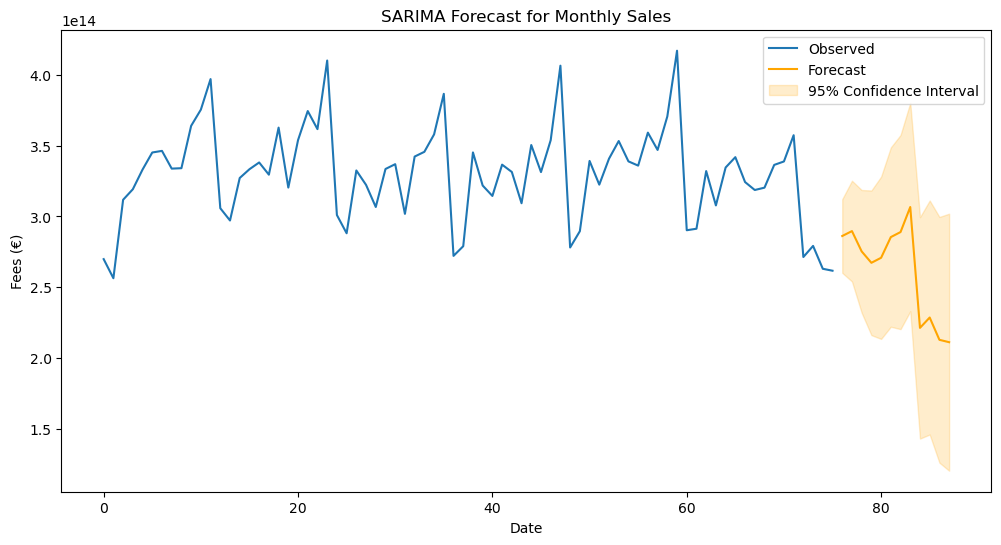

In [36]:
# Plot the observed data
plt.figure(figsize=(12,6))
plt.plot(monthly_totals.index, monthly_totals["INVOICE_FEE_EUROS"], label='Observed')

# Forecasted values
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast', color='orange')

# Confidence intervals
plt.fill_between(
    forecast_df.index,
    forecast_df['mean_ci_lower'],
    forecast_df['mean_ci_upper'],
    color='orange', alpha=0.2, label='95% Confidence Interval'
)

plt.title("SARIMA Forecast for Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Fees (€)")
plt.legend()
plt.show()

__This model effectively captures the behavioral complexity of time series forecasting for a multinational company.__